In [1]:
import numpy as np 
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import regex as re

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
%pip install -U huggingface_hub
import os
import random
import glob
from torch import no_grad
import torch.nn as nn
from torch import tensor
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Note: you may need to restart the kernel to use updated packages.


In [2]:
train_file = "/kaggle/input/nlp-getting-started/train.csv"
test_file = "/kaggle/input/nlp-getting-started/test.csv"

In [3]:
# load the CSV file into a pandas DataFrame
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Preprocessing

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

def clean_tweet_text(tweet):
    # convert to lowercase
    tweet = tweet.lower()
    
    # remove HTML tags using Beautiful Soup
    tweet = BeautifulSoup(tweet, "html.parser").get_text()
    
    # remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)

    # remove the "#" symbol from hashtags, keeping the content
    tweet = re.sub(r'#(\w+)', r'\1', tweet)

    # remove emojis 
    tweet = re.sub(r'\p{Emoji}', '', tweet)
    
    # remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # join tokens back into a cleaned tweet
    cleaned_tweet = ' '.join(filtered_tokens)
    
    return cleaned_tweet



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
train_df['cleaned_tweet'] = train_df['text'].apply(clean_tweet_text)

/tmp/ipykernel_28/2561126160.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, "html.parser").get_text()


In [8]:
train_df.head()

,id,keyword,location,text,target,cleaned_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [9]:
sentences = train_df.cleaned_tweet.values
labels = train_df.target.values

In [10]:
print(len(labels))


7613


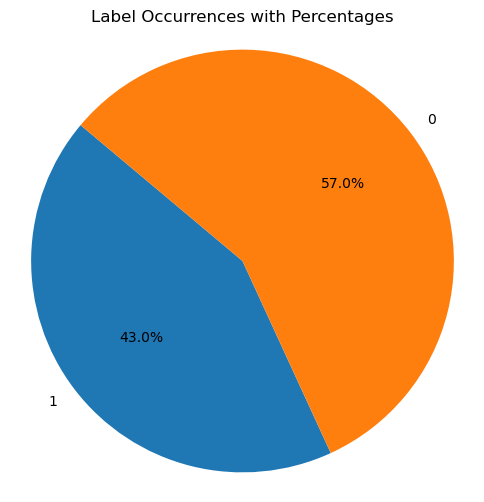

In [11]:
label_counts = Counter(labels)

# Plotting a pie chart
label_name = label_counts.keys()
sizes = label_counts.values()
total_items = sum(sizes)
percentages = [(count / total_items) * 100 for count in sizes]

plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=label_name, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Label Occurrences with Percentages")
plt.show()

In [12]:
# Split data into train and validation sets
train_tweets, val_tweets, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [13]:
print(train_tweets)

['courageous honest analysis need use atomic bomb hiroshima japanese military refused surrender'
 'wld b shame golf cart became engulfed flames boycottbears'
 'tell rescind medals honor given us soldiers massacre wounded knee sign rt'
 ... 'omron hemc automatic blood pressure monitor standard large bp cuffs'
 'officials say quarantine place alabama home possible ebola case developing symptoms'
 'moved england five years ago today whirlwind time']


In [14]:
print(len(val_tweets))

1523


## Loading BERT Tokenizer and Model

In [15]:
# random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [16]:
# load a pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
train_tweets = [str(tweet) for tweet in train_tweets]
val_tweets = [str(tweet) for tweet in val_tweets]

# tokenize the text data
train_inputs = tokenizer(train_tweets, padding=True, truncation=True, return_tensors="pt")
val_inputs = tokenizer(val_tweets, padding=True, truncation=True, return_tensors="pt")

# convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)

# create DataLoader for training and validation sets
train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, train_labels)
val_dataset = TensorDataset(val_inputs.input_ids, val_inputs.attention_mask, val_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# define optimizer and loss function
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()

# training loop
num_epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [17]:
for epoch in range(num_epochs):
    bert_model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader)}")
    print()

Epoch 1/4
Train Loss: 0.4970107063030203

Epoch 2/4
Train Loss: 0.36375538585707545

Epoch 3/4
Train Loss: 0.30102428995693725

Epoch 4/4
Train Loss: 0.23623783498381576



In [18]:
# evaluation on the test set
bert_model.eval()
test_loss = 0.0
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1), labels)
        test_loss += loss.item()
        test_predictions.extend(torch.sigmoid(logits).cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# calculate test accuracy
test_predictions = np.array(test_predictions) > 0.5
test_accuracy = accuracy_score(test_true_labels, test_predictions)

print(f"Test Loss: {test_loss / len(val_loader)}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.5132646697262923
Test Accuracy: 81.02%


In [20]:
def predict_disaster(text):

    cleaned_text = clean_tweet_text(text)
    inputs = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors="pt")

    # forward pass through the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # get the logits from the model's output
    logits = outputs.logits

    
    prediction = torch.sigmoid(logits) > 0.5

    return prediction.item()  # returns 1 if it's a disaster, 0 if it's not

# example usage:
input_text = "#WildfireAlert🔥: Evacuations ordered as a fast-spreading wildfire threatens homes in the area. Stay safe and follow local authorities' instructions!"
result = predict_disaster(input_text)
if result == 1:
    print("It's a disaster.")
else:
    print("It's not a disaster.")

It's a disaster.
